In [72]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

In [73]:
if os.path.isdir("mitdb"):
    print('You already have the data.')
else:
    wfdb.dl_database('mitdb', 'mitdb')

You already have the data.


In [74]:
record = wfdb.rdsamp('mitdb/107', sampto=3000)
annotation = wfdb.rdann('mitdb/107', 'atr', sampto=3000)

In [75]:
record[0]

array([[-2.045, -1.245],
       [-2.045, -1.245],
       [-2.045, -1.245],
       ...,
       [-0.645,  0.   ],
       [-0.63 ,  0.01 ],
       [-0.63 , -0.015]])

In [76]:
record[1]

{'fs': 360,
 'sig_len': 3000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V1'],
 'comments': ['63 M 1340 167 x1',
  'Digoxin',
  'Complete heart block is present. The PVCs are multiform.']}

Text(0, 0.5, 'Lead II')

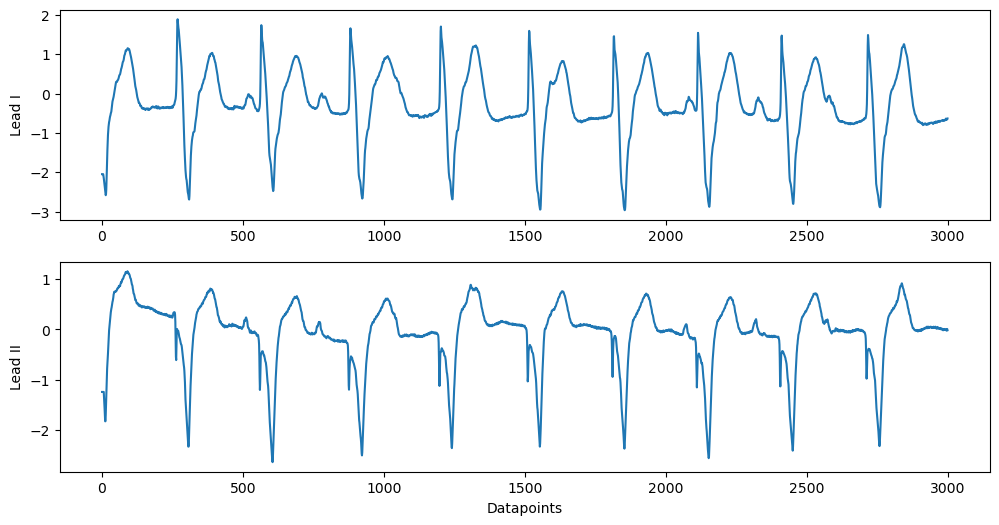

In [77]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6))
I = record[0][:, 0]
II = record[0][:, 1]

ax[0].plot(I)
ax[1].plot(II)
ax[0].set_ylabel('Lead I')
ax[1].set_xlabel('Datapoints')
ax[1].set_ylabel('Lead II')